## Apresentação 

Notebook destinado à criação de um chatbot que apresenta a capacidade de realizar resumos - para diminuir a quantidade de tokens informados até um outro node para produzir a resposta final - e memória. Tais estratégias se relacionam a um contexto da otimização da criação de chatbots em termos de custo computacional e financeiro, além de prover melhor experiência do usuário e aplicações com IA generativa mais robustas. 

### Librarys 

In [34]:
import getpass
import os

from dotenv import load_dotenv

from IPython.display import Image, display

from langchain_groq import ChatGroq

from langgraph.graph import (MessagesState, 
                             StateGraph,
                             START, 
                             END)

from langgraph.checkpoint.memory import MemorySaver

from langchain_core.messages import (SystemMessage, 
                                     HumanMessage, 
                                     RemoveMessage)

### Variável de ambiente

In [2]:
if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

### Modelo 

In [26]:
# Instanciando o modelo de LLM que será utilizado. 
llm = ChatGroq(
    model="llama-3.2-90b-text-preview",
    temperature=0.5,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

In [28]:
# Testando a conexão com a API. 
llm.invoke("BMTH é a sigla de qual banda ?").content

'BMTH é a sigla da banda britânica "Bring Me The Horizon".'

### Criando o chatbot 

In [29]:
# Criando a classe State, que irá provisionar a persistência de dados
# nos nodes da arquitetura. A classe herda MessagesState, um reducer 
# que aplica por padrão a adição de mensagens num formato de lista, 
# e não a sua sobre-escrita. 

class State(MessagesState): 
    summary : str

In [30]:
def call_model(state : State):

    """Função que chama o modelo de LLM utilizado e implementa
       uma funcionalidade de resumo, visando diminuir os custos
       financeiros e processamento da resposta do modelo. """


    # Extração do resumo por meio da chave "summary". 
    # Caso não exista resumo algum, é retornado vazio. 
    summary = state.get("summary", "")

    if summary:

        # Instrução ao sistema. 
        system_message = f"Summary of conversation earlier: {summary}"

        # Armazena a instrução ao sistema e as mensagens existentes. 
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:

        # Se não existir resumo, apenas retorna as mensagens. 
        messages = state["messages"]

    # Resposta do modelo. 
    response = llm.invoke(messages)
    return {"messages": response}


In [31]:
def summarize_conversation(state: State):

    """Função que realiza uma conversa."""

    # Extração do resumo por meio da chave "summary". 
    # Caso não exista resumo algum, é retornado vazio.
    summary = state.get("summary", "")
    
    if summary:
        
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Adiciona o resumo junto das mensagens recebidas. 
    messages = state["messages"] + [HumanMessage(content=summary_message)]

    response = llm.invoke(messages)

    return {"summary": response.content, "messages": messages}

In [33]:
def should_continue(state : State):

    """Função que verifica a necessidade de realizar
       o resumo da conversa ou não."""

    messages = state["messages"]

    # Critério lógico que decide que acima de 5 mensagens
    # o modelo irá chamar a função que realiza o resumo. 
    if len(messages) > 5:
        return "summarize_conversation"
    
    return END

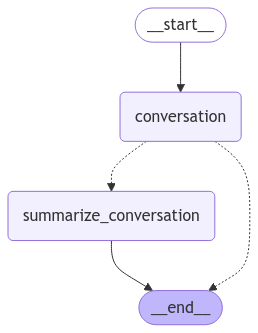

In [ ]:
# Construtor da arquitetura
workflow = StateGraph(State)

# Definindo os nodes presentes
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

# Definindo os entrypoints - por onde irá passar o fluxo. 
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue) # edge condicional que bifurca o fluxo.
workflow.add_edge("summarize_conversation", END)

# Definindo o checkpointer - criação de memória. 
memory = MemorySaver()
chatbot = workflow.compile(checkpointer=memory)

display(Image(chatbot.get_graph().draw_mermaid_png()))

In [38]:
# Criando a thread. 
config = {"configurable": {"thread_id": "1"}}

# Conversação. 
input_message = HumanMessage(content="hi! I'm Lance")
output = chatbot.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = chatbot.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="I like the BMTH!")
output = chatbot.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================ Human Message =================================

This is summary of the conversation to date: Here's the extended summary:

We had a brief chat where I greeted you, and you introduced yourself as Lance. You then asked me to recall your name, which I did. You also mentioned that you like the band Bring Me The Horizon (BMTH), and I responded by acknowledging the band and their evolution in sound. You then asked me to create a summary of our conversation, which I did. You pointed out a slight error in my summary, and I corrected it. Finally, you asked me to extend the summary to take into account the new messages, which I've done here. After that, you asked me to extend the summary again to take into account the new messages, and I provided the same summary. You then asked me to extend the summary once more, and I noted that the new message was a repeat of an earlier message, but I still provided an updated summary.

Extend the summary by taking into accou

KeyboardInterrupt: 